# Requirements

In [ ]:
from IPython.display import clear_output
!pip install itk
clear_output()
import sys
import itk
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
fixedImageFile = "/content/drive/MyDrive/ITK Registration/VF-MRT1-1014-1174.vtk"
movingImageFile = "/content/drive/MyDrive/ITK Registration/VF-MRT2-1014-1174.vtk"
outputImageFile = "/content/drive/MyDrive/ITK Registration/registered.vtk"
differenceImageAfterFile = "/content/drive/MyDrive/ITK Registration/difference_after.vtk"
differenceImageBeforeFile = "/content/drive/MyDrive/ITK Registration/difference_before.vtk"

# Functions

In [ ]:
def composite_img(regions, img1, img2):
  dim_slice = min(img1.shape[0], img2.shape[0])
  dim_x = img1.shape[2]
  n1 = regions[0]
  n2 = regions[1]
  for i in range(n1):
    for j in range(n2):
      if i%2 ==  0:
        x1 = img2
        x2 = img1
      else:
        x1 = img1
        x2 = img2

      if j == 0:
        comp_1_temp = x1[:dim_slice, ((i)*dim_x)//(n1):((i+1)*dim_x)//(n1), ((j)*dim_x)//(n2):((j+1)*dim_x)//(n2)]
        comp_2_temp = x2[:dim_slice, ((i)*dim_x)//(n1):((i+1)*dim_x)//(n1), ((j)*dim_x)//(n2):((j+1)*dim_x)//(n2)]
      else:
        if j%2 == 1:
          comp_1_temp = np.concatenate((comp_1_temp, x2[:dim_slice, ((i)*dim_x)//(n1):((i+1)*dim_x)//(n1), ((j)*dim_x)//(n2):((j+1)*dim_x)//(n2)]), axis = 2)
          comp_2_temp = np.concatenate((comp_2_temp, x1[:dim_slice, ((i)*dim_x)//(n1):((i+1)*dim_x)//(n1), ((j)*dim_x)//(n2):((j+1)*dim_x)//(n2)]), axis = 2)
        else:
          comp_1_temp = np.concatenate((comp_1_temp, x1[:dim_slice, ((i)*dim_x)//(n1):((i+1)*dim_x)//(n1), ((j)*dim_x)//(n2):((j+1)*dim_x)//(n2)]), axis = 2)
          comp_2_temp = np.concatenate((comp_2_temp, x2[:dim_slice, ((i)*dim_x)//(n1):((i+1)*dim_x)//(n1), ((j)*dim_x)//(n2):((j+1)*dim_x)//(n2)]), axis = 2)

    if i ==  0:
        comp_1 = comp_1_temp
        comp_2 = comp_2_temp
    else:
      comp_1 = np.concatenate((comp_1, comp_1_temp), axis = 1)
      comp_2 = np.concatenate((comp_2, comp_2_temp), axis = 1)
  return comp_1, comp_2

# Visulaization

In [ ]:
fixed_3d = itk.imread(fixedImageFile)
moving_3d = itk.imread(movingImageFile)

In [ ]:
fixed_3d.shape, moving_3d.shape 

((33, 256, 256), (63, 256, 256))

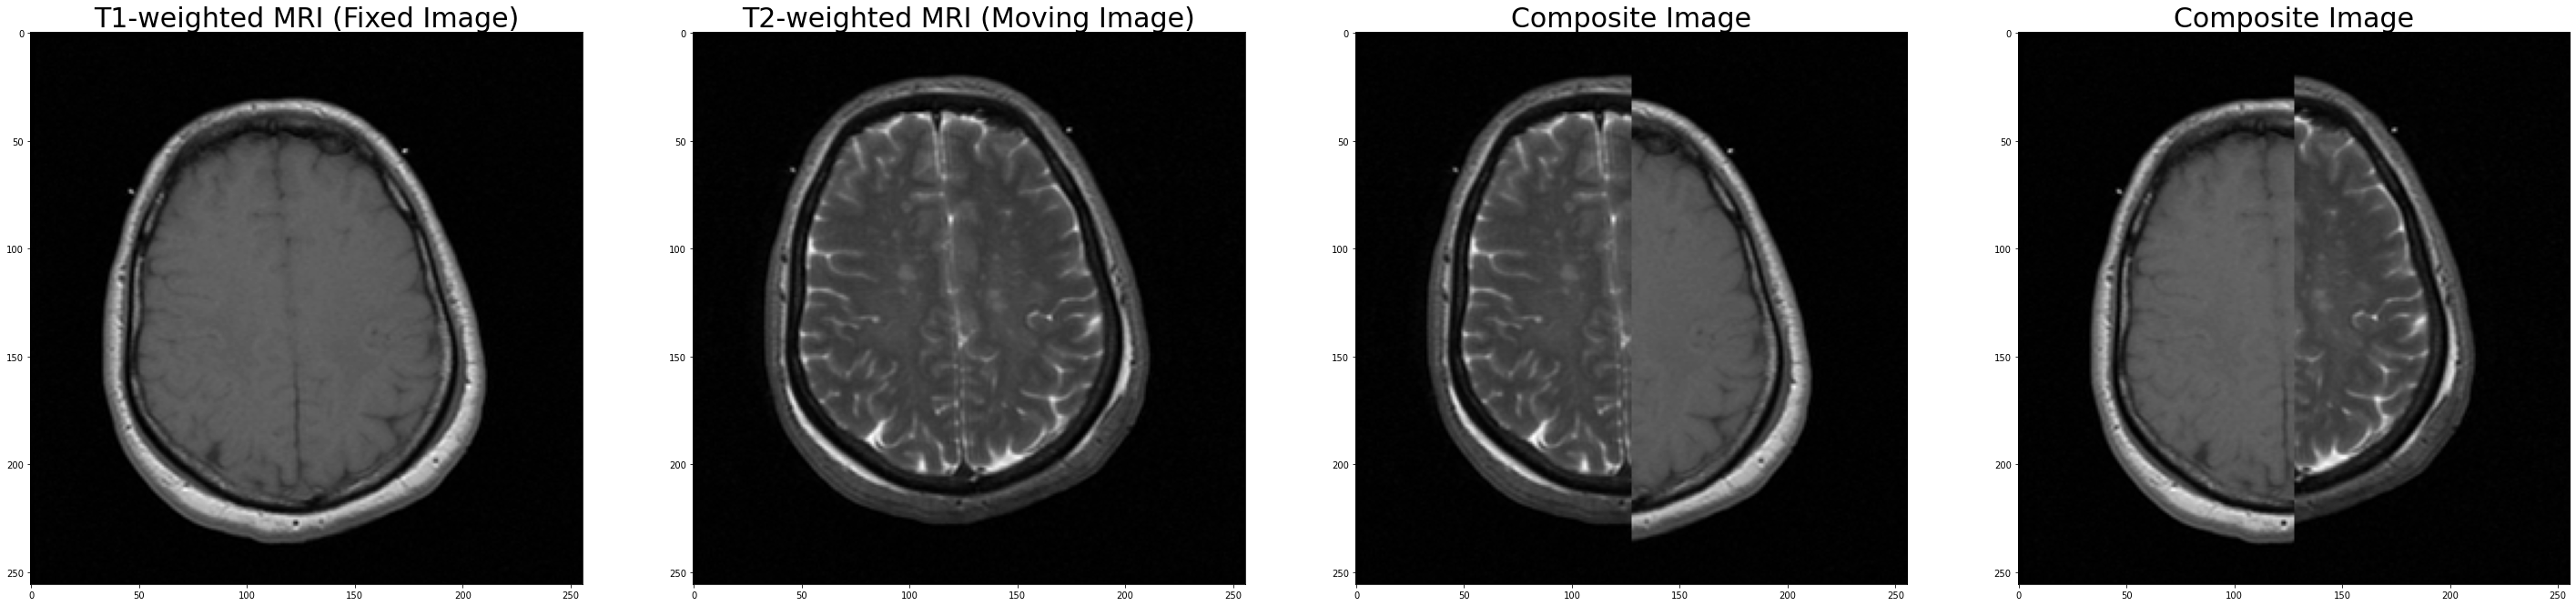

In [ ]:
slice = 10
n_regions = [1,2]
comp_1, comp_2 = composite_img(n_regions, fixed_3d, moving_3d)
fig, ax = plt.subplots(1, 4, figsize = (50, 25))
ax[0].imshow(fixed_3d[slice], cmap='gray'), ax[0].set_title(f'T1-weighted MRI (Fixed Image)',fontsize = 30);
ax[1].imshow(moving_3d[slice], cmap='gray'), ax[1].set_title(f'T2-weighted MRI (Moving Image)',fontsize = 30);
ax[2].imshow(comp_1[slice], cmap='gray'), ax[2].set_title(f'Composite Image',fontsize = 30);
ax[3].imshow(comp_2[slice], cmap='gray'), ax[3].set_title(f'Composite Image',fontsize = 30);

# Registration

In [503]:
PixelType = itk.F

fixedImage = itk.imread(fixedImageFile, PixelType)
movingImage = itk.imread(movingImageFile, PixelType)

Dimension = fixedImage.GetImageDimension()
FixedImageType = itk.Image[PixelType, Dimension]
MovingImageType = itk.Image[PixelType, Dimension]

print(f"Fixed Image Shape : {fixedImage.shape}")
print(f"Moving Image Shape : {movingImage.shape}")
print(f"Dimension : {Dimension}")

Fixed Image Shape : (33, 256, 256)
Moving Image Shape : (63, 256, 256)
Dimension : 3


## Transform

In [504]:
TransformType = itk.TranslationTransform[itk.D, Dimension]
initialTransform = TransformType.New()

movingInitialTransform = TransformType.New()
initialParameters = movingInitialTransform.GetParameters()
initialParameters[0] = 0
initialParameters[1] = 0
initialParameters[2] = 0
movingInitialTransform.SetParameters(initialParameters)

identityTransform = TransformType.New()
identityTransform.SetIdentity()

## Interpolator

In [505]:
interpolator = itk.LinearInterpolateImageFunction[FixedImageType,itk.D]
# interpolator = itk.NearestNeighborInterpolateImageFunction[FixedImageType,itk.D]
movingInterpolator = interpolator.New()
fixedInterpolator = interpolator.New()

## Metric

In [506]:
# metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()

MetricType = itk.MattesMutualInformationImageToImageMetricv4[FixedImageType, MovingImageType]
metric = MetricType.New()

numberOfBins = 24
metric.SetNumberOfHistogramBins(numberOfBins)
metric.SetUseMovingImageGradientFilter(False)
metric.SetUseFixedImageGradientFilter(False)
metric.SetFixedInterpolator(movingInterpolator)
metric.SetMovingInterpolator(fixedInterpolator)

## Optimizer

In [507]:
optimizer = itk.RegularStepGradientDescentOptimizerv4.New(LearningRate=4, MinimumStepLength=0.001, RelaxationFactor=0.5, NumberOfIterations=200)

## Registration

In [508]:
registration = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType].New(FixedImage=fixedImage, MovingImage=movingImage, Metric=metric, Optimizer=optimizer, InitialTransform=initialTransform)

registration.SetMovingInitialTransform(movingInitialTransform)
registration.SetFixedInitialTransform(identityTransform)

# registration.SetNumberOfLevels(1)
# registration.SetSmoothingSigmasPerLevel([0])
# registration.SetShrinkFactorsPerLevel([1])

registration.SetNumberOfLevels(2)
registration.SetSmoothingSigmasPerLevel([0, 0])
registration.SetShrinkFactorsPerLevel([2, 1])

# registration.SetNumberOfLevels(3)
# registration.SetSmoothingSigmasPerLevel([0, 0, 0])
# registration.SetShrinkFactorsPerLevel([3, 2, 1])

## Update

In [509]:
params = []
def iterationUpdate():
    transform = registration.GetTransform()
    currentParameter = transform.GetParameters()
    params.append([optimizer.GetCurrentIteration(), optimizer.GetValue(), currentParameter.GetElement(0), currentParameter.GetElement(1), currentParameter.GetElement(2)])
    print(
        "Iter: %i --> Metric: %f   Translation X: %f, Translation Y: %f, Translation Z: %f"
        % (
            optimizer.GetCurrentIteration(),
            optimizer.GetValue(),
            currentParameter.GetElement(0),
            currentParameter.GetElement(1),
            currentParameter.GetElement(2)
        )
    )

iterationCommand = itk.PyCommand.New()
iterationCommand.SetCommandCallable(iterationUpdate)
optimizer.AddObserver(itk.IterationEvent(), iterationCommand)


0

In [510]:
registration.Update()

transform = registration.GetTransform()
finalParameters = transform.GetParameters()
translationAlongX = finalParameters.GetElement(0)
translationAlongY = finalParameters.GetElement(1)
translationAlongZ = finalParameters.GetElement(2)

numberOfIterations = optimizer.GetCurrentIteration()

bestValue = optimizer.GetValue()

params.append([optimizer.GetCurrentIteration(), optimizer.GetValue(), finalParameters.GetElement(0), finalParameters.GetElement(1), finalParameters.GetElement(2)])


print("Result = ")
print(" Translation X = " + str(translationAlongX))
print(" Translation Y = " + str(translationAlongY))
print(" Translation Z = " + str(translationAlongZ))
print(" Iterations    = " + str(numberOfIterations))
print(" Metric value  = " + str(bestValue))

Iter: 0 --> Metric: -0.375328   Translation X: 0.315350, Translation Y: -3.871441, Translation Z: -0.955248
Iter: 1 --> Metric: -0.474470   Translation X: 0.225921, Translation Y: -7.750534, Translation Z: -1.927176
Iter: 2 --> Metric: -0.643016   Translation X: -0.808099, Translation Y: -11.535526, Translation Z: -1.149597
Iter: 3 --> Metric: -0.551881   Translation X: -0.148713, Translation Y: -9.651254, Translation Z: -1.028234
Iter: 4 --> Metric: -0.622835   Translation X: 0.342517, Translation Y: -7.713156, Translation Z: -1.077917
Iter: 5 --> Metric: -0.637864   Translation X: -0.043663, Translation Y: -8.625575, Translation Z: -1.213408
Iter: 6 --> Metric: -0.655039   Translation X: 0.243090, Translation Y: -8.217935, Translation Z: -1.253443
Iter: 7 --> Metric: -0.652402   Translation X: 0.032569, Translation Y: -8.348909, Translation Z: -1.285484
Iter: 8 --> Metric: -0.656562   Translation X: 0.119440, Translation Y: -8.435298, Translation Z: -1.310290
Iter: 9 --> Metric: -0.6

Text(0, 0.5, 'Metric')

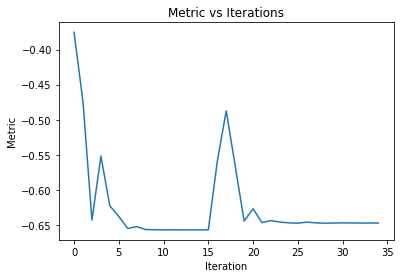

In [511]:
plt.plot(np.array([i for i in range(len(params))]), np.array(params)[:,1])
plt.title("Metric vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Metric")

Text(0, 0.5, 'Metric')

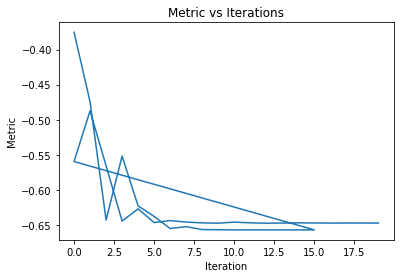

In [513]:
plt.plot(np.array(params)[:,0], np.array(params)[:,1])
plt.title("Metric vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Metric")

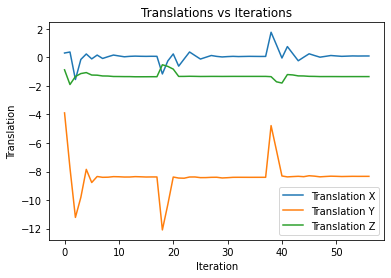

In [493]:
plt.plot(np.array([i for i in range(len(params))]), np.array(params)[:,2])
plt.plot(np.array([i for i in range(len(params))]), np.array(params)[:,3])
plt.plot(np.array([i for i in range(len(params))]), np.array(params)[:,4])
plt.title("Translations vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Translation")
plt.legend(["Translation X", "Translation Y", "Translation Z"])

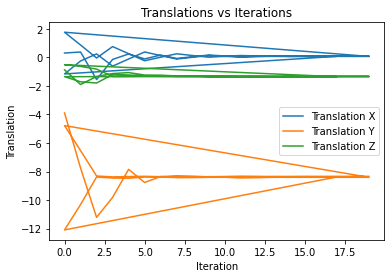

In [494]:
plt.plot(np.array(params)[:,0], np.array(params)[:,2])
plt.plot(np.array(params)[:,0], np.array(params)[:,3])
plt.plot(np.array(params)[:,0], np.array(params)[:,4])
plt.title("Translations vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Translation")
plt.legend(["Translation X", "Translation Y", "Translation Z"])

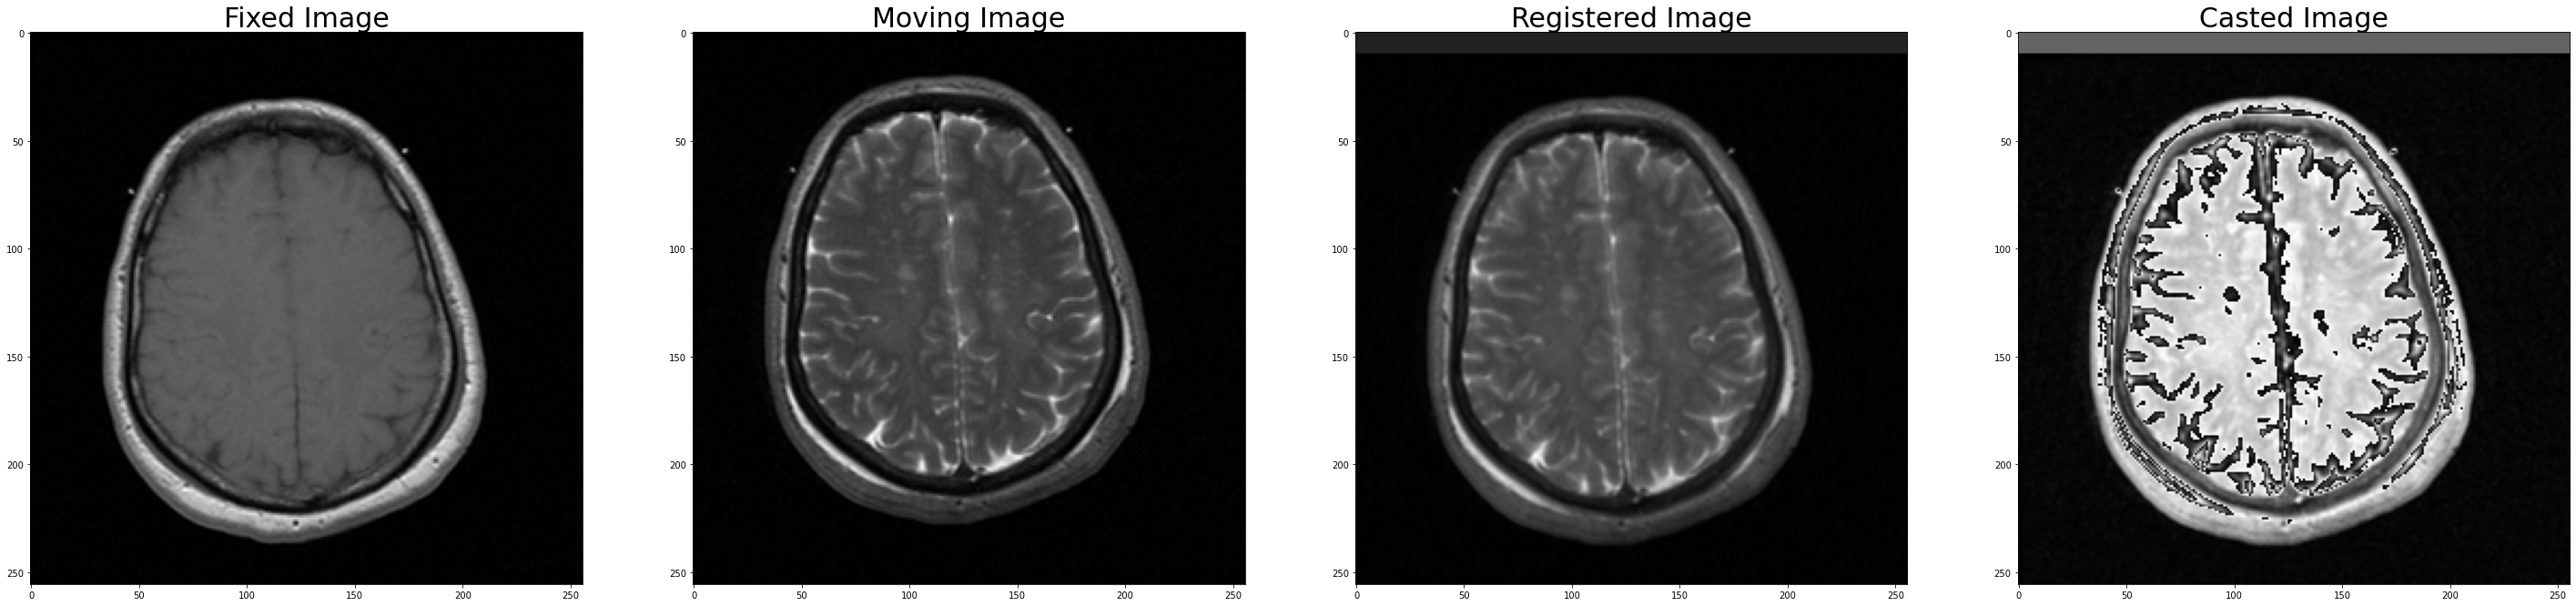

In [495]:
CompositeTransformType = itk.CompositeTransform[itk.D, Dimension]
outputCompositeTransform = CompositeTransformType.New()
outputCompositeTransform.AddTransform(movingInitialTransform)
outputCompositeTransform.AddTransform(registration.GetModifiableTransform())

resampler = itk.ResampleImageFilter.New(Input=movingImage, Transform=outputCompositeTransform, UseReferenceImage=True, ReferenceImage=fixedImage)
resampler.SetDefaultPixelValue(100)


OutputPixelType = itk.UC
OutputImageType = itk.Image[OutputPixelType, Dimension]
caster = itk.CastImageFilter[FixedImageType,OutputImageType].New(Input=resampler)
caster_3d = caster.GetOutput()

OutputPixelType = itk.F
OutputImageType = itk.Image[OutputPixelType, Dimension]

writer = itk.ImageFileWriter.New(Input = resampler, FileName = outputImageFile)
writer.SetFileName(outputImageFile)
writer.Update()

out_3d = resampler.GetOutput()

slice = 10
fig, ax = plt.subplots(1,4, figsize=(50,25))
ax[0].imshow(fixed_3d[slice], cmap='gray'), ax[0].set_title('Fixed Image', fontsize = 30)
ax[1].imshow(moving_3d[slice], cmap='gray'), ax[1].set_title('Moving Image', fontsize = 30)
ax[2].imshow(out_3d[slice], cmap='gray'), ax[2].set_title('Registered Image', fontsize = 30)
ax[3].imshow(caster_3d[slice], cmap='gray'), ax[3].set_title('Casted Image', fontsize = 30)
out_3d.shape

In [476]:
difference = itk.SubtractImageFilter.New(Input1=fixedImage, Input2=resampler)
intensityRescaler = itk.RescaleIntensityImageFilter[FixedImageType, OutputImageType].New(Input=difference, OutputMinimum=itk.NumericTraits[OutputPixelType].min(),
            OutputMaximum=itk.NumericTraits[OutputPixelType].max())


resampler.SetDefaultPixelValue(1)
writer.SetInput(intensityRescaler.GetOutput())
writer.SetFileName(differenceImageAfterFile)
writer.Update()
after_diff = intensityRescaler.GetOutput()

resampler_2 = itk.ResampleImageFilter.New(Input=movingImage, Transform=identityTransform, UseReferenceImage=True, ReferenceImage=fixedImage)
difference_2 = itk.SubtractImageFilter.New(Input1=fixedImage, Input2=resampler_2)
intensityRescaler_2 = itk.RescaleIntensityImageFilter[FixedImageType, OutputImageType].New(Input=difference_2, OutputMinimum=itk.NumericTraits[OutputPixelType].min(),
            OutputMaximum=itk.NumericTraits[OutputPixelType].max())
before_diff = intensityRescaler_2.GetOutput()

writer.SetInput(intensityRescaler_2.GetOutput())
writer.SetFileName(differenceImageBeforeFile)
writer.Update()

# Output Visualization

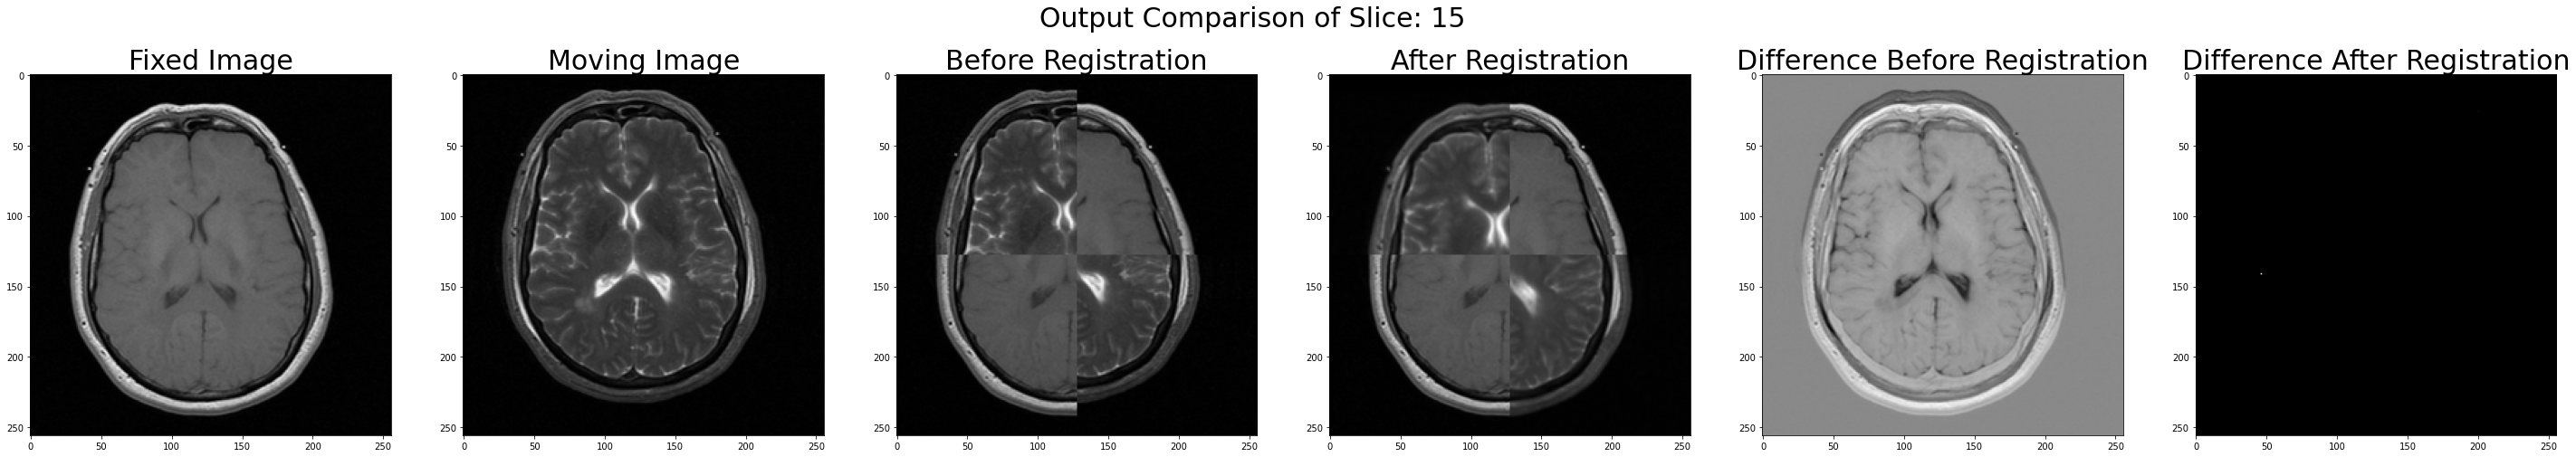

In [416]:
slice = 15
n_regions = [2,2]
before_comp_1, before_comp_2 = composite_img(n_regions, fixed_3d, moving_3d)
after_comp_1, after_comp_2 = composite_img(n_regions, fixed_3d, out_3d)

fig, ax = plt.subplots(1,6, figsize=(50,8))
fig.suptitle(f'Output Comparison of Slice: {slice}', fontsize = 30)
ax[0].imshow(fixed_3d[slice], cmap='gray'), ax[0].set_title('Fixed Image', fontsize = 30)
ax[1].imshow(moving_3d[slice], cmap='gray'), ax[1].set_title('Moving Image', fontsize = 30)
ax[2].imshow(before_comp_1[slice], cmap='gray'), ax[2].set_title('Before Registration', fontsize = 30)
ax[3].imshow(after_comp_1[slice], cmap='gray'), ax[3].set_title('After Registration', fontsize = 30);
ax[4].imshow(before_diff[slice], cmap='gray'), ax[4].set_title('Difference Before Registration', fontsize = 30)
ax[5].imshow(after_diff[slice], cmap='gray'), ax[5].set_title('Difference After Registration', fontsize = 30);

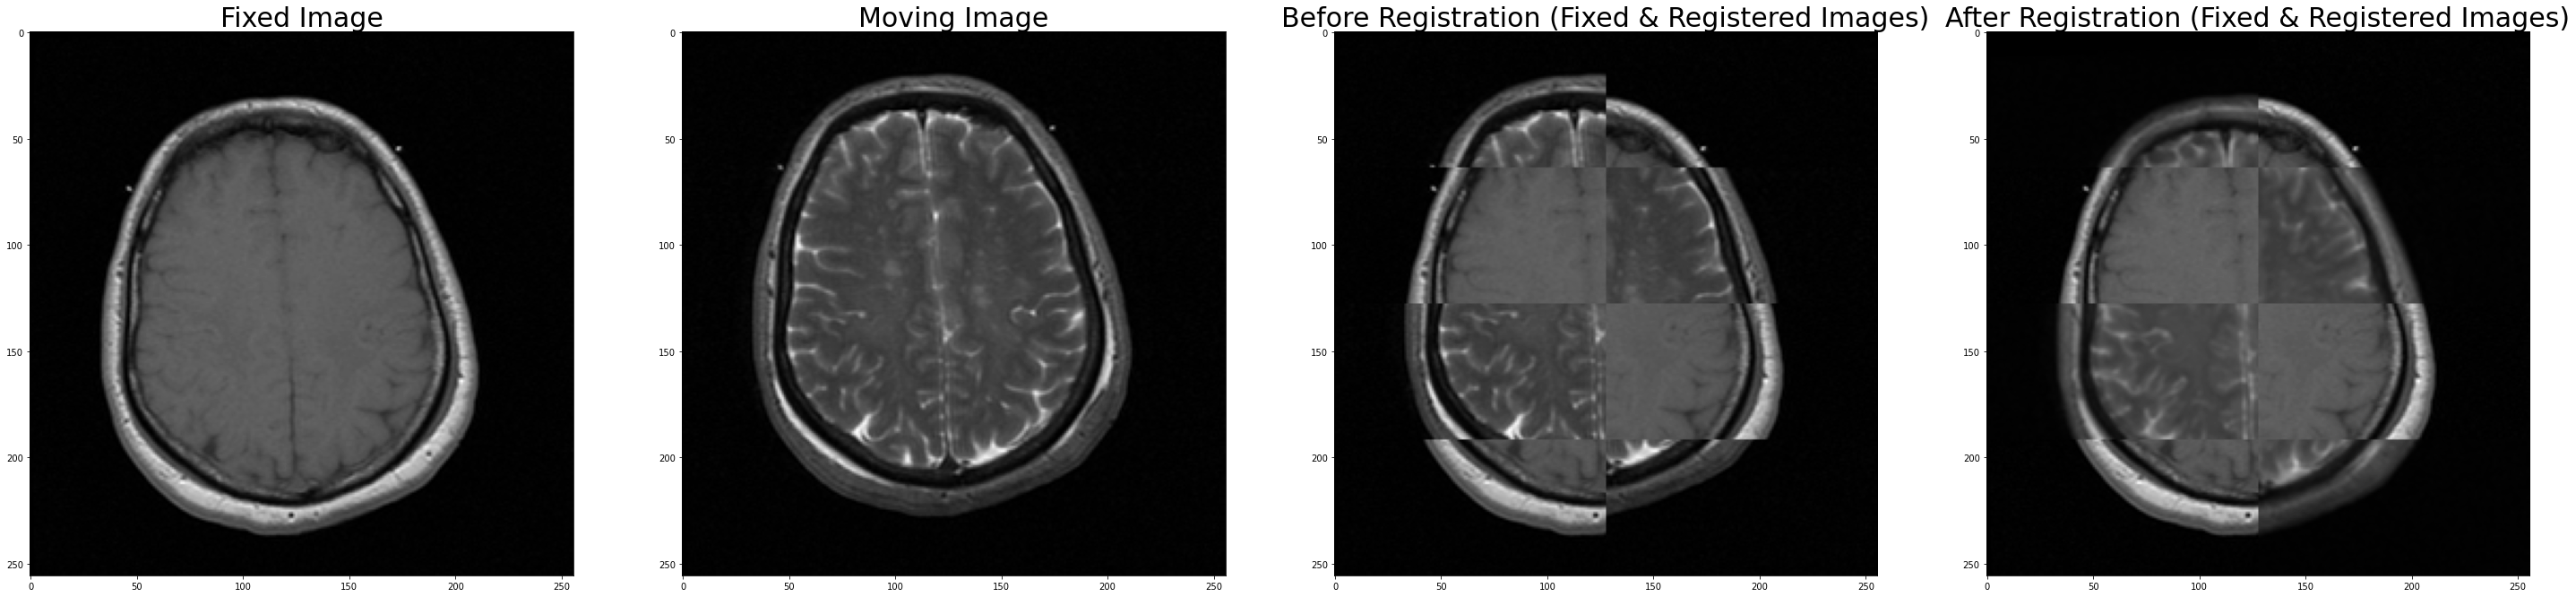

In [356]:
import numpy as np
slice = 10
n_regions = [4,2]

before_comp_1, before_comp_2 = composite_img(n_regions, fixed_3d, moving_3d)
after_comp_1, after_comp_2 = composite_img(n_regions, fixed_3d, out_3d)

fig, ax = plt.subplots(1,4, figsize=(50,25))
ax[0].imshow(fixed_3d[slice], cmap='gray'), ax[0].set_title('Fixed Image', fontsize = 30)
ax[1].imshow(moving_3d[slice], cmap='gray'), ax[1].set_title('Moving Image', fontsize = 30)
ax[2].imshow(before_comp_1[slice], cmap='gray'), ax[2].set_title('Before Registration (Fixed & Registered Images)', fontsize = 30)
ax[3].imshow(after_comp_1[slice], cmap='gray'), ax[3].set_title('After Registration (Fixed & Registered Images)', fontsize = 30);

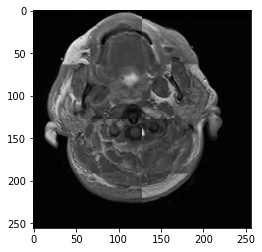

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

frames = [] # for storing the generated images
fig = plt.figure()
for i in (range(33)):
    frames.append([plt.imshow(after_comp_2[i], cmap='gray', animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True, repeat_delay=1000)
ani.save('after_registration_image.mp4')
plt.show()